## Assignment 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [8]:
data = pd.read_csv('comments.tsv', sep='\t')

In [9]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [10]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [11]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [16]:
# task: preprocess each comment in train and test

texts_train = np.array([preprocess(x) for x in texts_train])
texts_test = np.array([preprocess(x) for x in texts_test])

In [17]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [279]:
from collections import OrderedDict, Counter
from sklearn.base import TransformerMixin
from typing import List, Union
import numpy as np

In [280]:
class BoW(TransformerMixin):
    """
    Bag of words tranformer class
    
    check out:
    https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html
    to know about TransformerMixin class
    """

    def __init__(self, k: int):
        """
        :param k: number of most frequent tokens to use
        """
        self.k = k
        # list of k most frequent tokens
        self.bow = None

    def fit(self, X: np.ndarray, y=None):
        """
        :param X: array of texts to be trained on
        """
        # task: find up to self.k most frequent tokens in texts_train,
        # sort them by number of occurences (highest first)
        # store most frequent tokens in self.bow
        text_counter = Counter()
        for text in X:
            text_counter.update(text.split(' '))

        self.bow = [x[0] for x in text_counter.most_common(self.k)]
        # fit method must always return self
        return self

    def _text_to_bow(self, text: str) -> np.ndarray:
        """
        convert text string to an array of token counts. Use self.bow.
        :param text: text to be transformed
        :return bow_feature: feature vector, made by bag of words
        """

        result = [0] * self.k
        for token in text.split(' '):
            try:
                result[self.bow.index(token)] += 1
            except ValueError:
                pass
        return np.array(result, "float32")

    def transform(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.bow is not None
        return np.stack([self._text_to_bow(text) for text in X])

    def get_vocabulary(self) -> Union[List[str], None]:
        return self.bow

# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

bow = BoW(k)
bow.fit(texts_train)

print('example features:', sorted(bow.get_vocabulary())[::100])

example features: ['!', '12/13', '3', ']', 'adolf', 'altered', 'arcane', 'automatically', 'benefit', 'bottom', 'cambefort', 'chemistry', 'comb-like', 'consume', 'credited', 'decided', 'diatribe', 'doing', 'education', 'essay', 'factual', 'fire', 'from', 'go', 'hands', 'hinders', 'identical', 'infobox', 'israelis', 'kind', "let's", 'lost', 'mckenna', 'moderation', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [281]:
# Small check that everything is done properly
bow_vocabulary = bow.get_vocabulary()
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [282]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

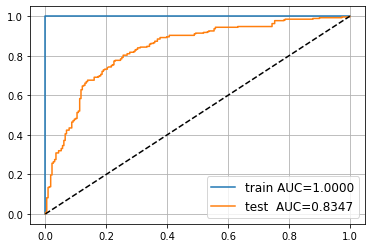

In [283]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [284]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [285]:
from utils import plot_train_process

In [286]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(k, 2))

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [287]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [288]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [289]:
lr_scheduler = StepLR(opt, step_size=5, gamma=0.1)

In [290]:
X_train_bow_torch = torch.tensor(X_train_bow)
X_test_bow_torch = torch.tensor(X_test_bow)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

Let's test that everything is fine

In [291]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [292]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [296]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

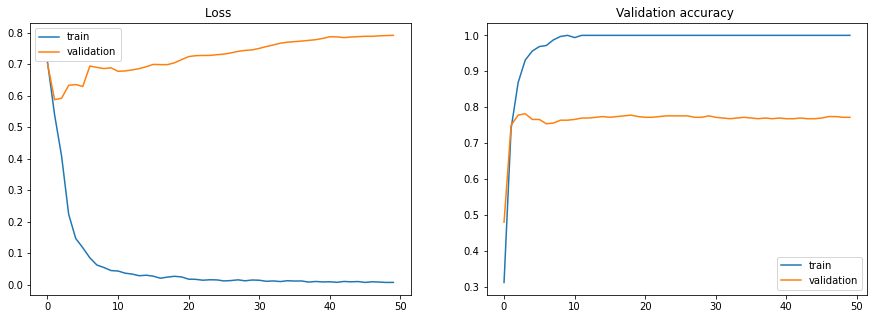

Sequential(
  (l1): Linear(in_features=5707, out_features=2, bias=True)
)

In [299]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

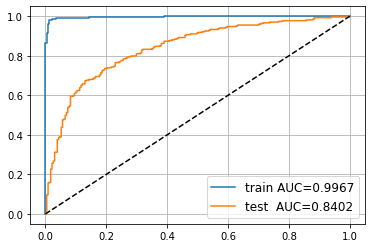

In [295]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

resetting  l1
resetting  l1
resetting  l1
resetting  l1


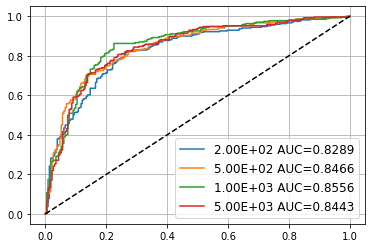

In [278]:
def plot_auc(k):
    k = min(k, len(set(' '.join(texts_train).split())))

    bow = BoW(k)
    bow.fit(texts_train)

    X_train_bow = bow.transform(texts_train)
    X_test_bow = bow.transform(texts_test)
    
    X_train_bow_torch = torch.tensor(X_train_bow)
    X_test_bow_torch = torch.tensor(X_test_bow)
    
    model = nn.Sequential()

    model.add_module('l1', nn.Linear(k, 2))
    
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    
    lr_scheduler = StepLR(opt, step_size=5, gamma=0.1)
    
    train_model(
        model, opt, lr_scheduler, X_train_bow_torch, 
        y_train_torch, X_test_bow_torch, y_test_torch, show_plots=False
    )
    
    proba = model(X_test_bow_torch).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y_test, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%.2E AUC=%.4f' % (k, auc))

for k in [int(2*1e2), int(5*1e2), int(1e+3), int(5*1e3)]:
    plot_auc(k)

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [406]:
from collections import OrderedDict

class TfIdf(TransformerMixin):
    """
    Tf-Idf tranformer class
    if you have troubles implementing Tf-Idf, check out:
    https://streamsql.io/blog/tf-idf-from-scratch
    """

    def __init__(self, k: int = None, normalize: bool = False):
        """
        :param k: number of most frequent tokens to use
        if set k equals None, than all words in train must be considered
        :param normalize: if True, you must normalize each data sample
        after computing tf-idf features
        """
        self.k = k
        self.normalize = normalize

        # self.idf[term] = log(total # of documents / # of documents with term in it)
        self.idf = OrderedDict()

    def fit(self, X: np.ndarray, y=None):
        """
        :param X: array of texts to be trained on
        """
        freq_counter = Counter()
        docs_counter = Counter()
        N = X.shape[0]
        for doc in X:
            tokens = doc.split(' ')
            freq_counter.update(tokens)
            docs_counter.update(np.unique(tokens))
            
        k = self.k or len(freq_counter)
        for token,_ in freq_counter.most_common(k):
            self.idf[token] = np.log(N/docs_counter[token])
        
        return self

    def _text_to_tf_idf(self, text: str) -> np.ndarray:
        """
        convert text string to an array tf-idfs.
        *Note* don't forget to normalize, when self.normalize == True
        :param text: text to be transformed
        :return tf_idf: tf-idf features
        """
        freq_counter = Counter()
        freq_counter.update(text.split(' '))
        result = []
        for token, idf in self.idf.items():
            result.append(freq_counter.get(token, 0) * idf)
        
        result = np.array(result)
        if self.normalize:
            norm = max(sum(result), 1e-8)
            result = result / norm
        return np.array(result, "float32")

    def transform(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.idf is not None
        return np.stack([self._text_to_tf_idf(text) for text in X])


Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

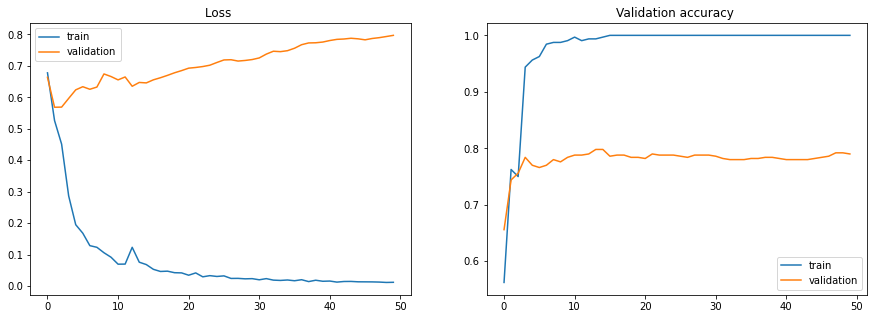

Sequential(
  (l1): Linear(in_features=5707, out_features=2, bias=True)
)

In [407]:
k = min(10000, len(set(' '.join(texts_train).split())))

tf_idf = TfIdf(k)
tf_idf.fit(texts_train)

X_train_tf_idf = tf_idf.transform(texts_train)
X_test_tf_idf = tf_idf.transform(texts_test)

X_train_tf_idf_torch = torch.tensor(X_train_bow)
X_test_tf_idf_torch = torch.tensor(X_test_bow)

model_unn = nn.Sequential()

model_unn.add_module('l1', nn.Linear(k, 2))

opt = torch.optim.Adam(model_unn.parameters(), lr=0.01)

lr_scheduler = StepLR(opt, step_size=5, gamma=0.1)

train_model(
        model_unn, opt, lr_scheduler, X_train_tf_idf_torch, 
        y_train_torch, X_test_tf_idf_torch, y_test_torch
    )

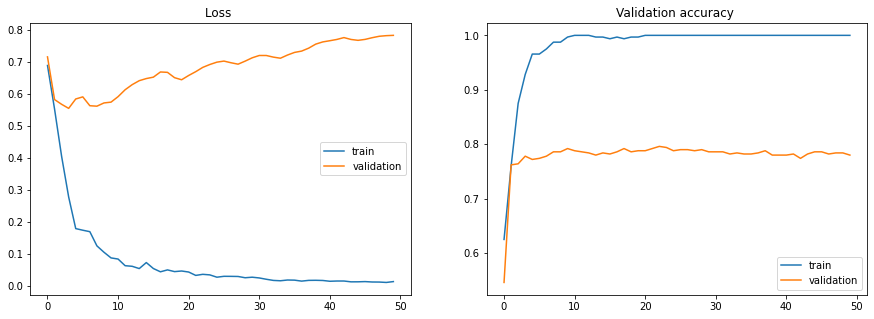

Sequential(
  (l1): Linear(in_features=5707, out_features=2, bias=True)
)

In [408]:
tf_idf = TfIdf(k, normalize=True)
tf_idf.fit(texts_train)

X_train_tf_idf = tf_idf.transform(texts_train)
X_test_tf_idf = tf_idf.transform(texts_test)

X_train_tf_idf_torch = torch.tensor(X_train_bow)
X_test_tf_idf_torch = torch.tensor(X_test_bow)

model_norm = nn.Sequential()

model_norm.add_module('l1', nn.Linear(k, 2))

opt = torch.optim.Adam(model_norm.parameters(), lr=0.01)

lr_scheduler = StepLR(opt, step_size=5, gamma=0.1)

train_model(
        model_norm, opt, lr_scheduler, X_train_tf_idf_torch, 
        y_train_torch, X_test_tf_idf_torch, y_test_torch
    )

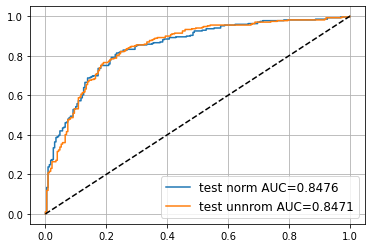

In [409]:
for name, X, y, model in [
    ('test norm', X_test_bow_torch, y_test, model_norm),
    ('test unnrom', X_test_bow_torch, y_test, model_unn)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

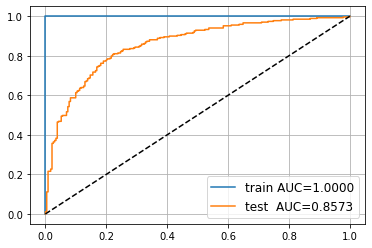

In [410]:
n_iterations=500
batch_size=16

tf_idf = TfIdf(k, normalize=True)
tf_idf.fit(texts_train)

X_train_tf_idf = tf_idf.transform(texts_train)
X_test_tf_idf = tf_idf.transform(texts_test)

X_train_tf_idf_torch = torch.tensor(X_train_bow)
X_test_tf_idf_torch = torch.tensor(X_test_bow)

model = nn.Sequential()

model.add_module('l1', nn.Linear(k, 2))

opt = torch.optim.Adam(model.parameters(), lr=0.01)

lr_scheduler = StepLR(opt, step_size=5, gamma=0.1)

train_model(
        model, opt, lr_scheduler, X_train_tf_idf_torch, 
        y_train_torch, X_test_tf_idf_torch, y_test_torch, show_plots=False,
        n_iterations=n_iterations, batch_size=batch_size
    )

display.clear_output(wait=True)

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

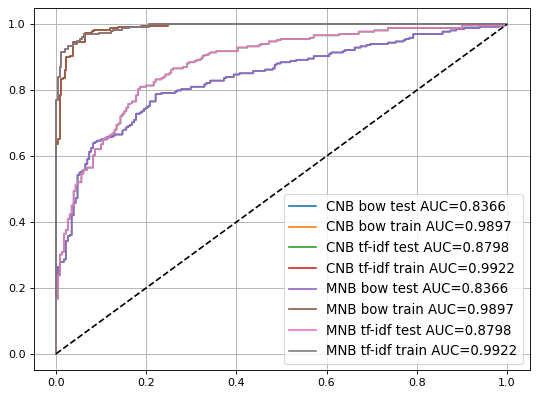

In [425]:
from sklearn.naive_bayes import ComplementNB, MultinomialNB

tf_idf = TfIdf(k, normalize=True)
tf_idf.fit(texts_train)

X_train_tf_idf = tf_idf.transform(texts_train)
X_test_tf_idf = tf_idf.transform(texts_test)

bow = BoW(k)
bow.fit(texts_train)

X_train_bow = bow.transform(texts_train)
X_test_bow = bow.transform(texts_test)
plt.figure(figsize=(8, 6), dpi=80)

for model, model_name in [
    (ComplementNB(), 'CNB'), 
    (MultinomialNB(), 'MNB')
]:
    for (X_train, X_test, emb_name) in [
        (X_train_bow, X_test_bow, 'bow'), 
        (X_train_tf_idf, X_test_tf_idf, 'tf-idf')
    ]:
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, proba)
        plt.plot(*roc_curve(y_test, proba)[:2], label='%s %s test AUC=%.4f' % (model_name, emb_name, auc))
        
        proba = model.predict_proba(X_train)[:,1]
        auc = roc_auc_score(y_train, proba)
        plt.plot(*roc_curve(y_train, proba)[:2], label='%s %s train AUC=%.4f' % (model_name, emb_name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

Кажется что основная проблема моделей тут - это переобучение потому что данных мало, и по этому смена lr и shedulter step не сильно помогает в случае log reg, по поводу Naive Bayes кажется что tf-idf работает лучше просто потому что априорное распределение чутка лушче приблежает в этом случае

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [509]:
import gensim.downloader as api


model_gen = api.load('glove-twitter-100')

[===-----------------------------------------------] 7.2% 27.9/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 15.1% 58.6/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 23.5% 90.9/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.8% 126.9/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 45.0% 174.2/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.7% 207.7/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 62.3% 241.2/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 71.1% 275.2/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================-------] 87.4% 338.2/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.7% 370.6/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 387.1/387.1MB downloaded


In [514]:
word_filter = model_gen.key_to_index

In [553]:
from tqdm import tqdm

def transform(texts, func):
    res = []
    for doc in tqdm(texts):
        tmp = []
        for token in doc:
            if token in word_filter:
                tmp.append(model_gen.get_vector(token))
        res.append(func(tmp, axis=0))
    return np.array(res, "float32")

X_train_gen_mean = transform(texts_train, np.mean)
X_test_gen_mean = transform(texts_test, np.mean)

100%|██████████| 500/500 [00:00<00:00, 3254.43it/s]


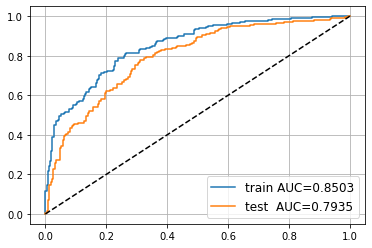

In [554]:
X_train_gen_mean_torch = torch.tensor(X_train_gen_mean)
X_test_gen_mean_torch = torch.tensor(X_test_gen_mean)

model = nn.Sequential()

model.add_module('l1', nn.Linear(100, 2))

opt = torch.optim.Adam(model.parameters(), lr=0.1)

lr_scheduler = StepLR(opt, step_size=5, gamma=0.1)

train_model(
        model, opt, lr_scheduler, X_train_gen_mean_torch, 
        y_train_torch, X_test_gen_mean_torch, y_test_torch, show_plots=False,
        n_iterations=int(1e4), batch_size=128
    )
display.clear_output(wait=True)

for name, X, y, model in [
    ('train', X_train_gen_mean_torch, y_train, model),
    ('test ', X_test_gen_mean_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()